In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
! pip install seaborn==0.13.2

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean
from datetime import datetime

In [4]:
# file_paths = {
#     "msl128vs30_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240824/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl128vs30cls_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240825/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl256vs30_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl256vs30cls_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv")
# }

file_paths = {
    #"msl128vs30_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128ae_bn_vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    #"msl128vs30cls_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    "ProtienBert": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/sarscov2_variants_s_prediction_results_20240902_224534.csv"),
    "ProtienBert-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/sarscov2_variants_s_prediction_results_20240903_132845.csv"),
    "VirProBert-msl1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240903/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_msl1366/tl_tf_multi_sarscov2_variants_s.csv"),
    "Hybd-sl256s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    "Hybd-sl256s64_CLS_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
}

In [5]:
dfs = []
for k, v in file_paths.items():
    df = pd.read_csv(v)
    df["model"] = k
    if "ProtienBert" not in k:
        df["id"] = df["id"].str.extract(r"\['(.+)'\]")
    index_seq_pred = df[df["id"] == "WIV04"]["Human"].values[0]
    df["Human_pred_diff"] = df["Human"] - index_seq_pred
    dfs.append(df)
df = pd.concat(dfs)
df

,Unnamed: 0,Human,Pig,Dromedary camel,Yak,Chicken,Cattle,Cat,Gray wolf,id,y_true,model_seq_len,model,Human_pred_diff
0,0.0,0.949289,0.018780,0.011292,0.000011,0.002964,0.011717,0.004549,0.001398,WIV04,Human,2048.0,ProtienBert,0.000000
1,1.0,0.948755,0.018350,0.010952,0.000012,0.003158,0.012370,0.005089,0.001315,QQM19141.1,Human,2048.0,ProtienBert,-0.000534
2,2.0,0.955693,0.010351,0.012207,0.000018,0.004215,0.010046,0.005394,0.002076,QQX30509.1,Human,2048.0,ProtienBert,0.006404
3,3.0,0.956184,0.015881,0.009332,0.000011,0.002854,0.009942,0.004577,0.001220,QRF70806.1,Human,2048.0,ProtienBert,0.006895
4,4.0,0.956088,0.016893,0.009431,0.000010,0.002951,0.010196,0.003480,0.000951,QRN78347.1,Human,2048.0,ProtienBert,0.006799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,NaN,0.776964,0.000172,0.006209,0.004281,0.019199,0.004093,0.172910,0.016173,QRX49325.1,Human,NaN,Hybd-sl256s64_CLS_UA,0.001810
14,NaN,0.739309,0.000636,0.013751,0.007132,0.060211,0.006921,0.130808,0.041232,QRF70806.1,Human,NaN,Hybd-sl256s64_CLS_UA,-0.035844
15,NaN,0.775153,0.000183,0.005820,0.004419,0.016971,0.004191,0.176626,0.016637,WIV04,Human,NaN,Hybd-sl256s64_CLS_UA,0.000000
16,NaN,0.775957,0.000208,0.006709,0.004526,0.020532,0.004305,0.171275,0.016489,QQM19141.1,Human,NaN,Hybd-sl256s64_CLS_UA,0.000803


In [6]:
df

,Unnamed: 0,Human,Pig,Dromedary camel,Yak,Chicken,Cattle,Cat,Gray wolf,id,y_true,model_seq_len,model,Human_pred_diff
0,0.0,0.949289,0.018780,0.011292,0.000011,0.002964,0.011717,0.004549,0.001398,WIV04,Human,2048.0,ProtienBert,0.000000
1,1.0,0.948755,0.018350,0.010952,0.000012,0.003158,0.012370,0.005089,0.001315,QQM19141.1,Human,2048.0,ProtienBert,-0.000534
2,2.0,0.955693,0.010351,0.012207,0.000018,0.004215,0.010046,0.005394,0.002076,QQX30509.1,Human,2048.0,ProtienBert,0.006404
3,3.0,0.956184,0.015881,0.009332,0.000011,0.002854,0.009942,0.004577,0.001220,QRF70806.1,Human,2048.0,ProtienBert,0.006895
4,4.0,0.956088,0.016893,0.009431,0.000010,0.002951,0.010196,0.003480,0.000951,QRN78347.1,Human,2048.0,ProtienBert,0.006799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,NaN,0.776964,0.000172,0.006209,0.004281,0.019199,0.004093,0.172910,0.016173,QRX49325.1,Human,NaN,Hybd-sl256s64_CLS_UA,0.001810
14,NaN,0.739309,0.000636,0.013751,0.007132,0.060211,0.006921,0.130808,0.041232,QRF70806.1,Human,NaN,Hybd-sl256s64_CLS_UA,-0.035844
15,NaN,0.775153,0.000183,0.005820,0.004419,0.016971,0.004191,0.176626,0.016637,WIV04,Human,NaN,Hybd-sl256s64_CLS_UA,0.000000
16,NaN,0.775957,0.000208,0.006709,0.004526,0.020532,0.004305,0.171275,0.016489,QQM19141.1,Human,NaN,Hybd-sl256s64_CLS_UA,0.000803


In [7]:
mapping_df = pd.read_csv(os.path.join(os.getcwd(), "..","..", "..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_Variants_ViralZone.csv"))

In [8]:
mapping_df = mapping_df[~mapping_df["seq"].isna()]
mapping_df

,pango_lineage,who_name,tag,emergence_location,emergence_date,spike_mutations,seq,virus_host_name
0,BA.1,Omicron,Variant of Concern,South Africa,Dec-21,"A67V, H69-, V70-, T95I, G142D, V143-, Y144-, Y...",UFO69279.1,Homo sapiens
1,BA.2,Omicron,Variant of Concern,South Africa,Dec-21,"T19I, L24-, P25-, P26-, A27S, G142D, V213G, G3...",OM371884.1,Homo sapiens
2,BA.2.12.1,Omicron,Variant of Concern,North-America,Dec-21,"T19I, L24-, P25-, P26-, A27S, G142D, V213G, G3...",OM958567.1,Homo sapiens
3,BA.2.75,Omicron,Variant of Concern,India,Jun-22,"T19I, L24-, P25-, P26-, A27S, G142D, K147E, W1...",ON990685.1,Homo sapiens
4,JN.1,Omicron,Variant of Concern,Luxembourg,Jan-23,"A27S, A264D, A570V, D405N, D614G, D796Y, E484K...",WRK13149.1,Homo sapiens
5,BA.4,Omicron,Variant of Concern,South Africa,Jan-22,"T19I, L24-, P25-, P26-, A27S, H69-, V70-, V213...",UPP14409.1,Homo sapiens
6,BA.5,Omicron,Variant of Concern,South Africa,Jan-22,"T19I, L24-, P25-, P26-, A27S, H69-, V70-, V213...",UOZ45804.1,Homo sapiens
7,BQ.1.1,Omicron,Variant of Concern,Nigeria,Jul-22,"T19I, L24-, P25-, P26-, A27S, H69-, V70-, V213...",UWM38596.1,Homo sapiens
8,EG.5.1,Omicron,Variant of Concern,Indonesia/France/China,Jan-23,"A27S, D405N, D614G, D796Y, E484A, F456L, F486P...",WGM84363.1,Homo sapiens
9,XBB.1.5,Omicron,Variant of Concern,USA,Nov-22,"A27S, A475V, D405N, D614G, D796Y, E484A, F456L...",UZG29433.1,Homo sapiens


In [9]:
mapping_df["emergence_date"] = mapping_df["emergence_date"].apply(lambda x: datetime.strftime(datetime.strptime(x, '%b-%y'), '%m/%Y'))
mapping_df["emergence_date"] = pd.to_datetime(mapping_df["emergence_date"])

In [10]:
df = df.merge(mapping_df[["seq", "pango_lineage", "emergence_date"]], how="left", left_on="id", right_on="seq")

In [11]:
order = list(df.sort_values(by="emergence_date")["pango_lineage"].unique())

In [12]:
order

['WIV04',
 'B.1.1.28.1',
 'B.1.351',
 'B.1.1.7',
 'B.1.427, B.1.429',
 'B.1.1.28.2',
 'B.1.526',
 'B.1.617.2',
 'B.1.1.1.C37',
 'B.1.525',
 'B.1.617.1',
 'BA.1',
 'BA.4',
 'BA.5',
 'BQ.1.1',
 'XBB.1.5',
 'EG.5.1',
 'JN.1']

In [13]:
df[df["pango_lineage"] == "B.1.1.28.1"]

,Unnamed: 0,Human,Pig,Dromedary camel,Yak,Chicken,Cattle,Cat,Gray wolf,id,y_true,model_seq_len,model,Human_pred_diff,seq,pango_lineage,emergence_date
5,5.0,0.959447,0.014949,0.009181,0.000009,0.002958,9.744322e-03,0.002745,0.000967,QRX39425.1,Human,2048.0,ProtienBert,0.010158,QRX39425.1,B.1.1.28.1,2020-07-01
23,5.0,0.994680,0.000019,0.000443,0.000006,0.000003,5.629458e-07,0.004567,0.000281,QRX39425.1,Human,2048.0,ProtienBert-2048,0.003232,QRX39425.1,B.1.1.28.1,2020-07-01
42,NaN,0.720594,0.000362,0.000533,0.000477,0.000316,2.344896e-03,0.270619,0.004754,QRX39425.1,Human,NaN,VirProBert-msl1366,0.003564,QRX39425.1,B.1.1.28.1,2020-07-01
56,NaN,0.708623,0.001241,0.016821,0.010196,0.057048,6.709584e-03,0.172906,0.026455,QRX39425.1,Human,NaN,Hybd-sl256s64_UA,-0.017772,QRX39425.1,B.1.1.28.1,2020-07-01
73,NaN,0.769994,0.000195,0.006542,0.004351,0.019973,4.418216e-03,0.176900,0.017626,QRX39425.1,Human,NaN,Hybd-sl256s64_CLS_UA,-0.005159,QRX39425.1,B.1.1.28.1,2020-07-01


In [14]:
df

,Unnamed: 0,Human,Pig,Dromedary camel,Yak,Chicken,Cattle,Cat,Gray wolf,id,y_true,model_seq_len,model,Human_pred_diff,seq,pango_lineage,emergence_date
0,0.0,0.949289,0.018780,0.011292,0.000011,0.002964,0.011717,0.004549,0.001398,WIV04,Human,2048.0,ProtienBert,0.000000,WIV04,WIV04,2019-12-01
1,1.0,0.948755,0.018350,0.010952,0.000012,0.003158,0.012370,0.005089,0.001315,QQM19141.1,Human,2048.0,ProtienBert,-0.000534,QQM19141.1,"B.1.427, B.1.429",2020-09-01
2,2.0,0.955693,0.010351,0.012207,0.000018,0.004215,0.010046,0.005394,0.002076,QQX30509.1,Human,2048.0,ProtienBert,0.006404,QQX30509.1,B.1.1.28.2,2020-10-01
3,3.0,0.956184,0.015881,0.009332,0.000011,0.002854,0.009942,0.004577,0.001220,QRF70806.1,Human,2048.0,ProtienBert,0.006895,QRF70806.1,B.1.525,2020-12-01
4,4.0,0.956088,0.016893,0.009431,0.000010,0.002951,0.010196,0.003480,0.000951,QRN78347.1,Human,2048.0,ProtienBert,0.006799,QRN78347.1,B.1.351,2020-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,0.776964,0.000172,0.006209,0.004281,0.019199,0.004093,0.172910,0.016173,QRX49325.1,Human,NaN,Hybd-sl256s64_CLS_UA,0.001810,QRX49325.1,B.1.526,2020-11-01
86,NaN,0.739309,0.000636,0.013751,0.007132,0.060211,0.006921,0.130808,0.041232,QRF70806.1,Human,NaN,Hybd-sl256s64_CLS_UA,-0.035844,QRF70806.1,B.1.525,2020-12-01
87,NaN,0.775153,0.000183,0.005820,0.004419,0.016971,0.004191,0.176626,0.016637,WIV04,Human,NaN,Hybd-sl256s64_CLS_UA,0.000000,WIV04,WIV04,2019-12-01
88,NaN,0.775957,0.000208,0.006709,0.004526,0.020532,0.004305,0.171275,0.016489,QQM19141.1,Human,NaN,Hybd-sl256s64_CLS_UA,0.000803,QQM19141.1,"B.1.427, B.1.429",2020-09-01


<Figure size 432x288 with 0 Axes>

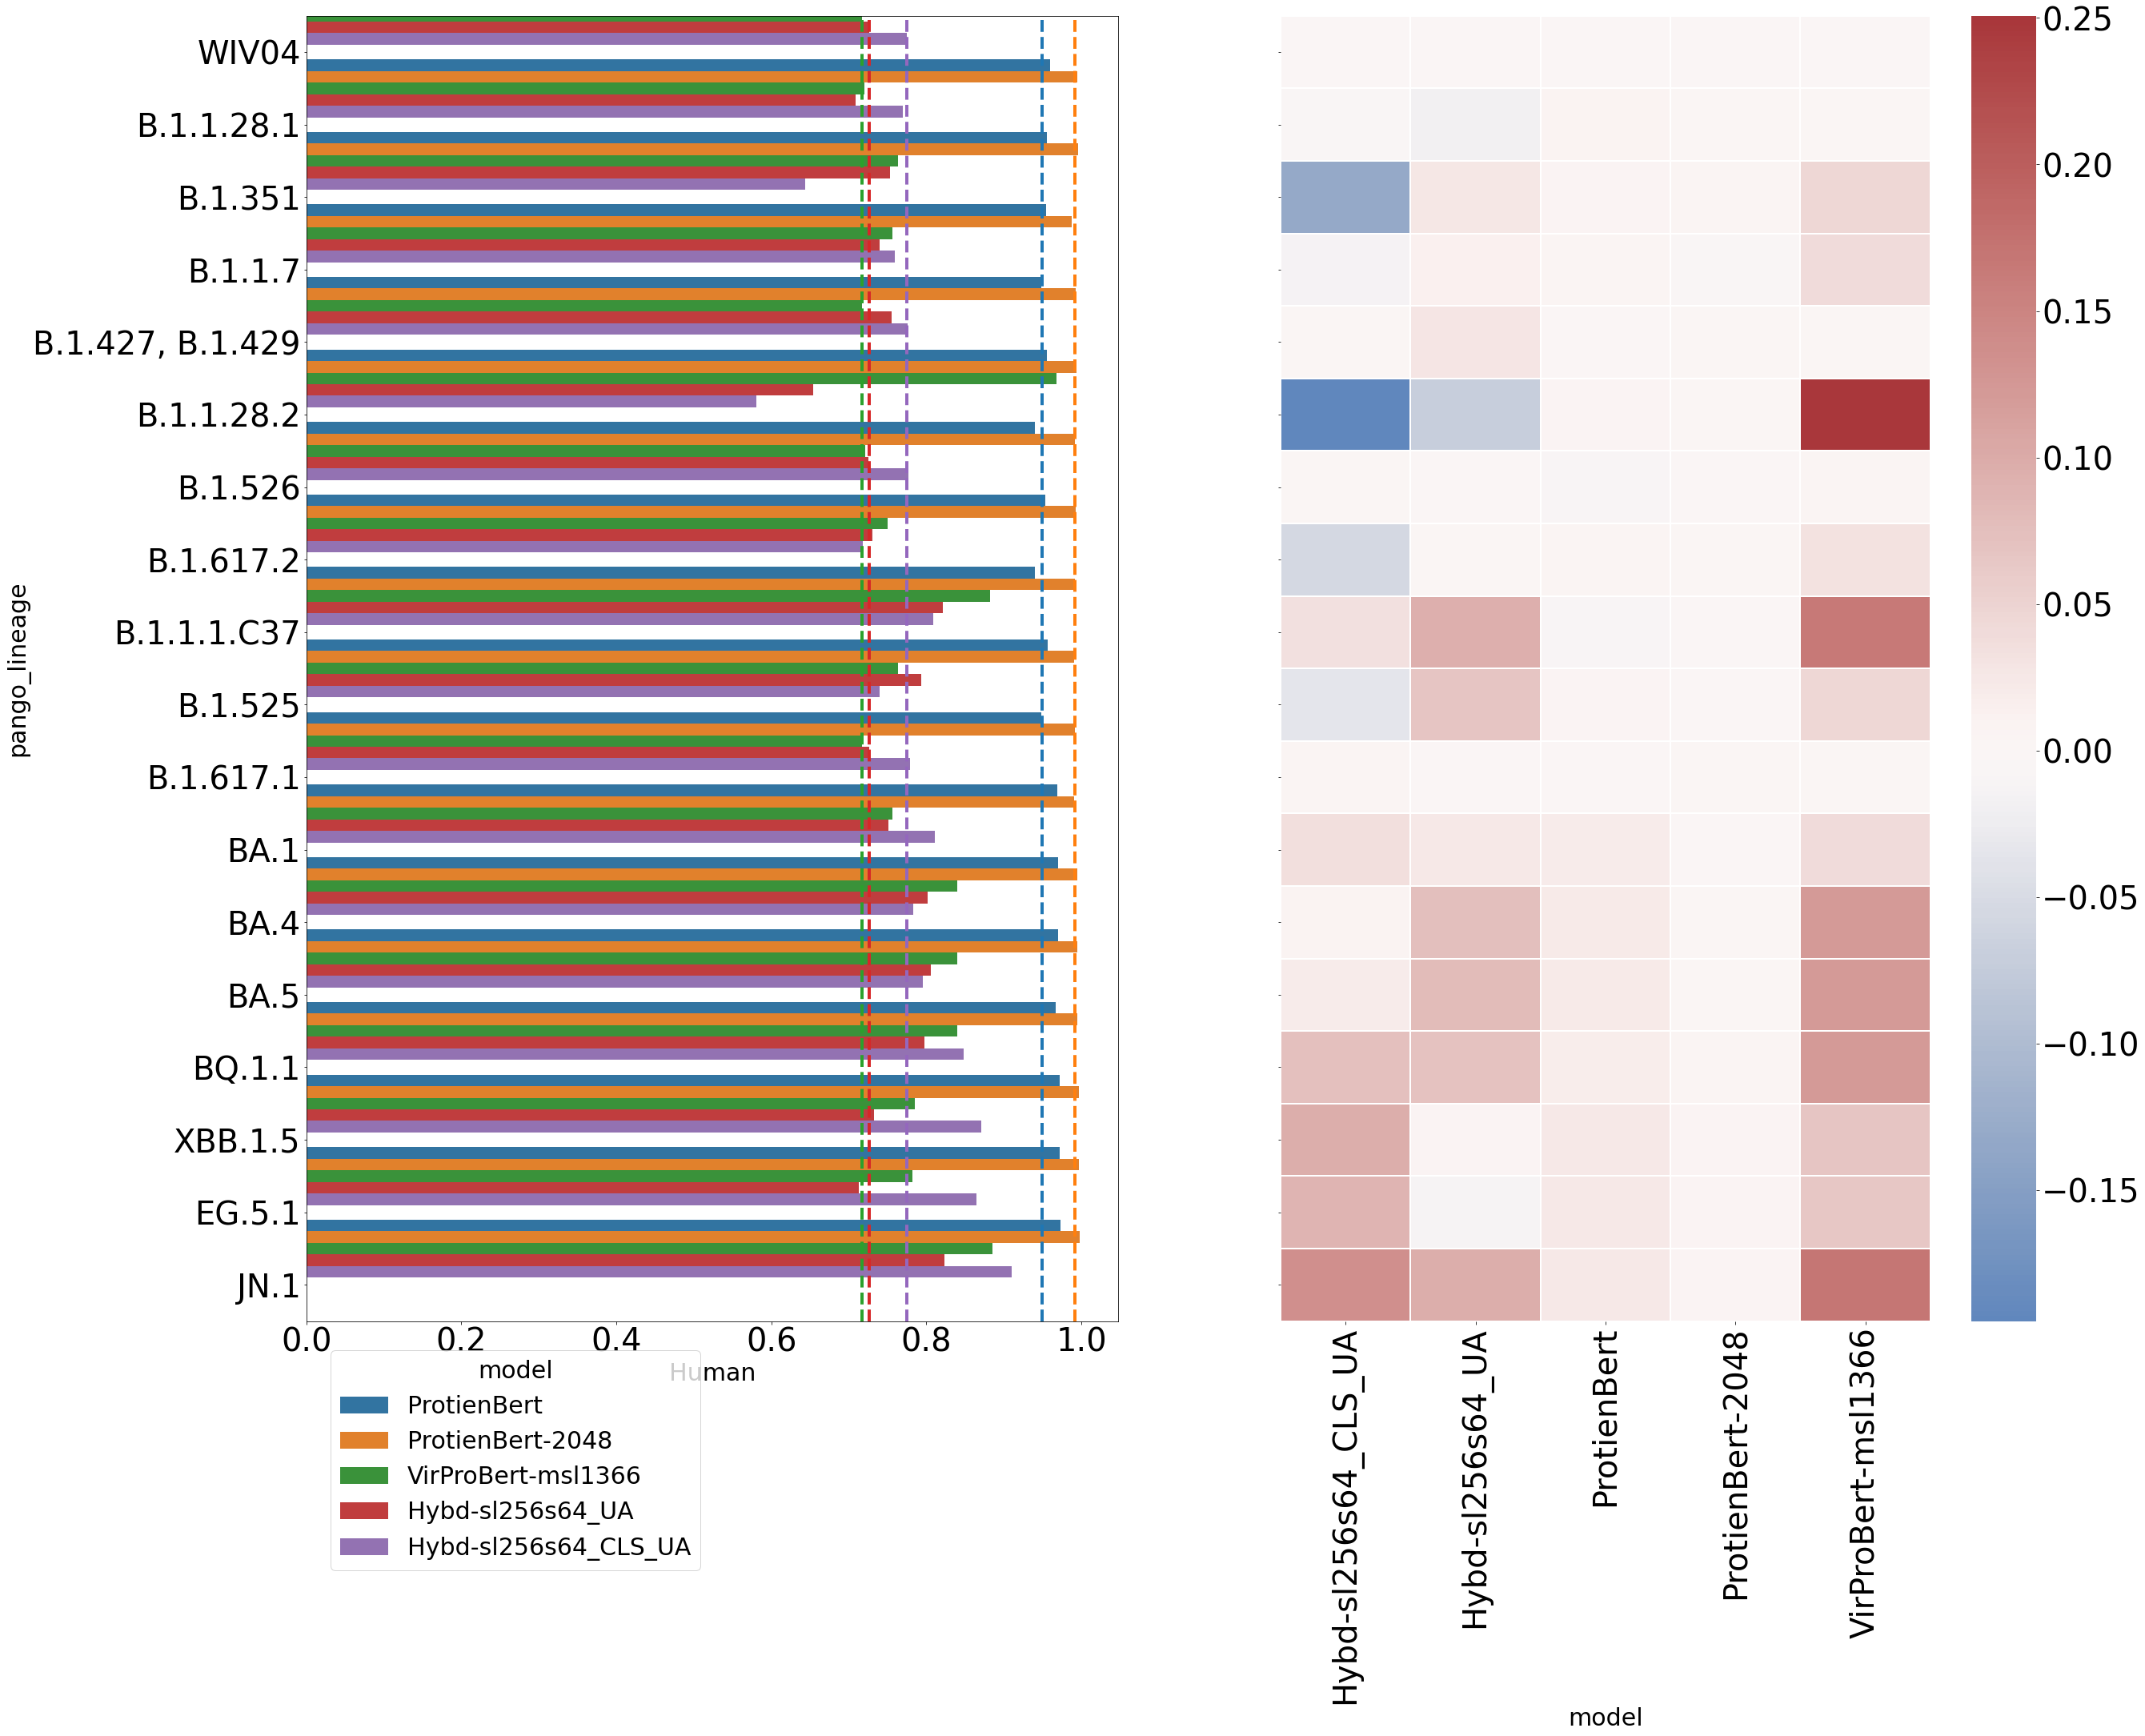

In [15]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 2, figsize=(40, 30), sharex=False, sharey=True)

colors = sns.color_palette('tab10')
models = list(df["model"].unique())

color_palette_dict = {k: v for k, v in zip(models, colors)}

sns.barplot(data=df,  x="Human", y="pango_lineage", hue="model", ax=axs[0], order=order)
               # boxprops={"facecolor": (.3, .5, .7, .5)})
sns.move_legend(axs[0], "lower right", bbox_to_anchor=(.5, -.2))

for model, color in zip(models, colors):
    axs[0].axvline(df[(df["model"] == model) & (df["id"] == "WIV04")]["Human"].values[0], color=color, linestyle="--", linewidth=4)

sns.heatmap(df.pivot(index="pango_lineage", columns="model", values="Human_pred_diff").reindex(order), ax=axs[1], linewidth=.1, center=0, cmap="vlag")
axs[1].set_ylabel("")
plt.show()
    
    


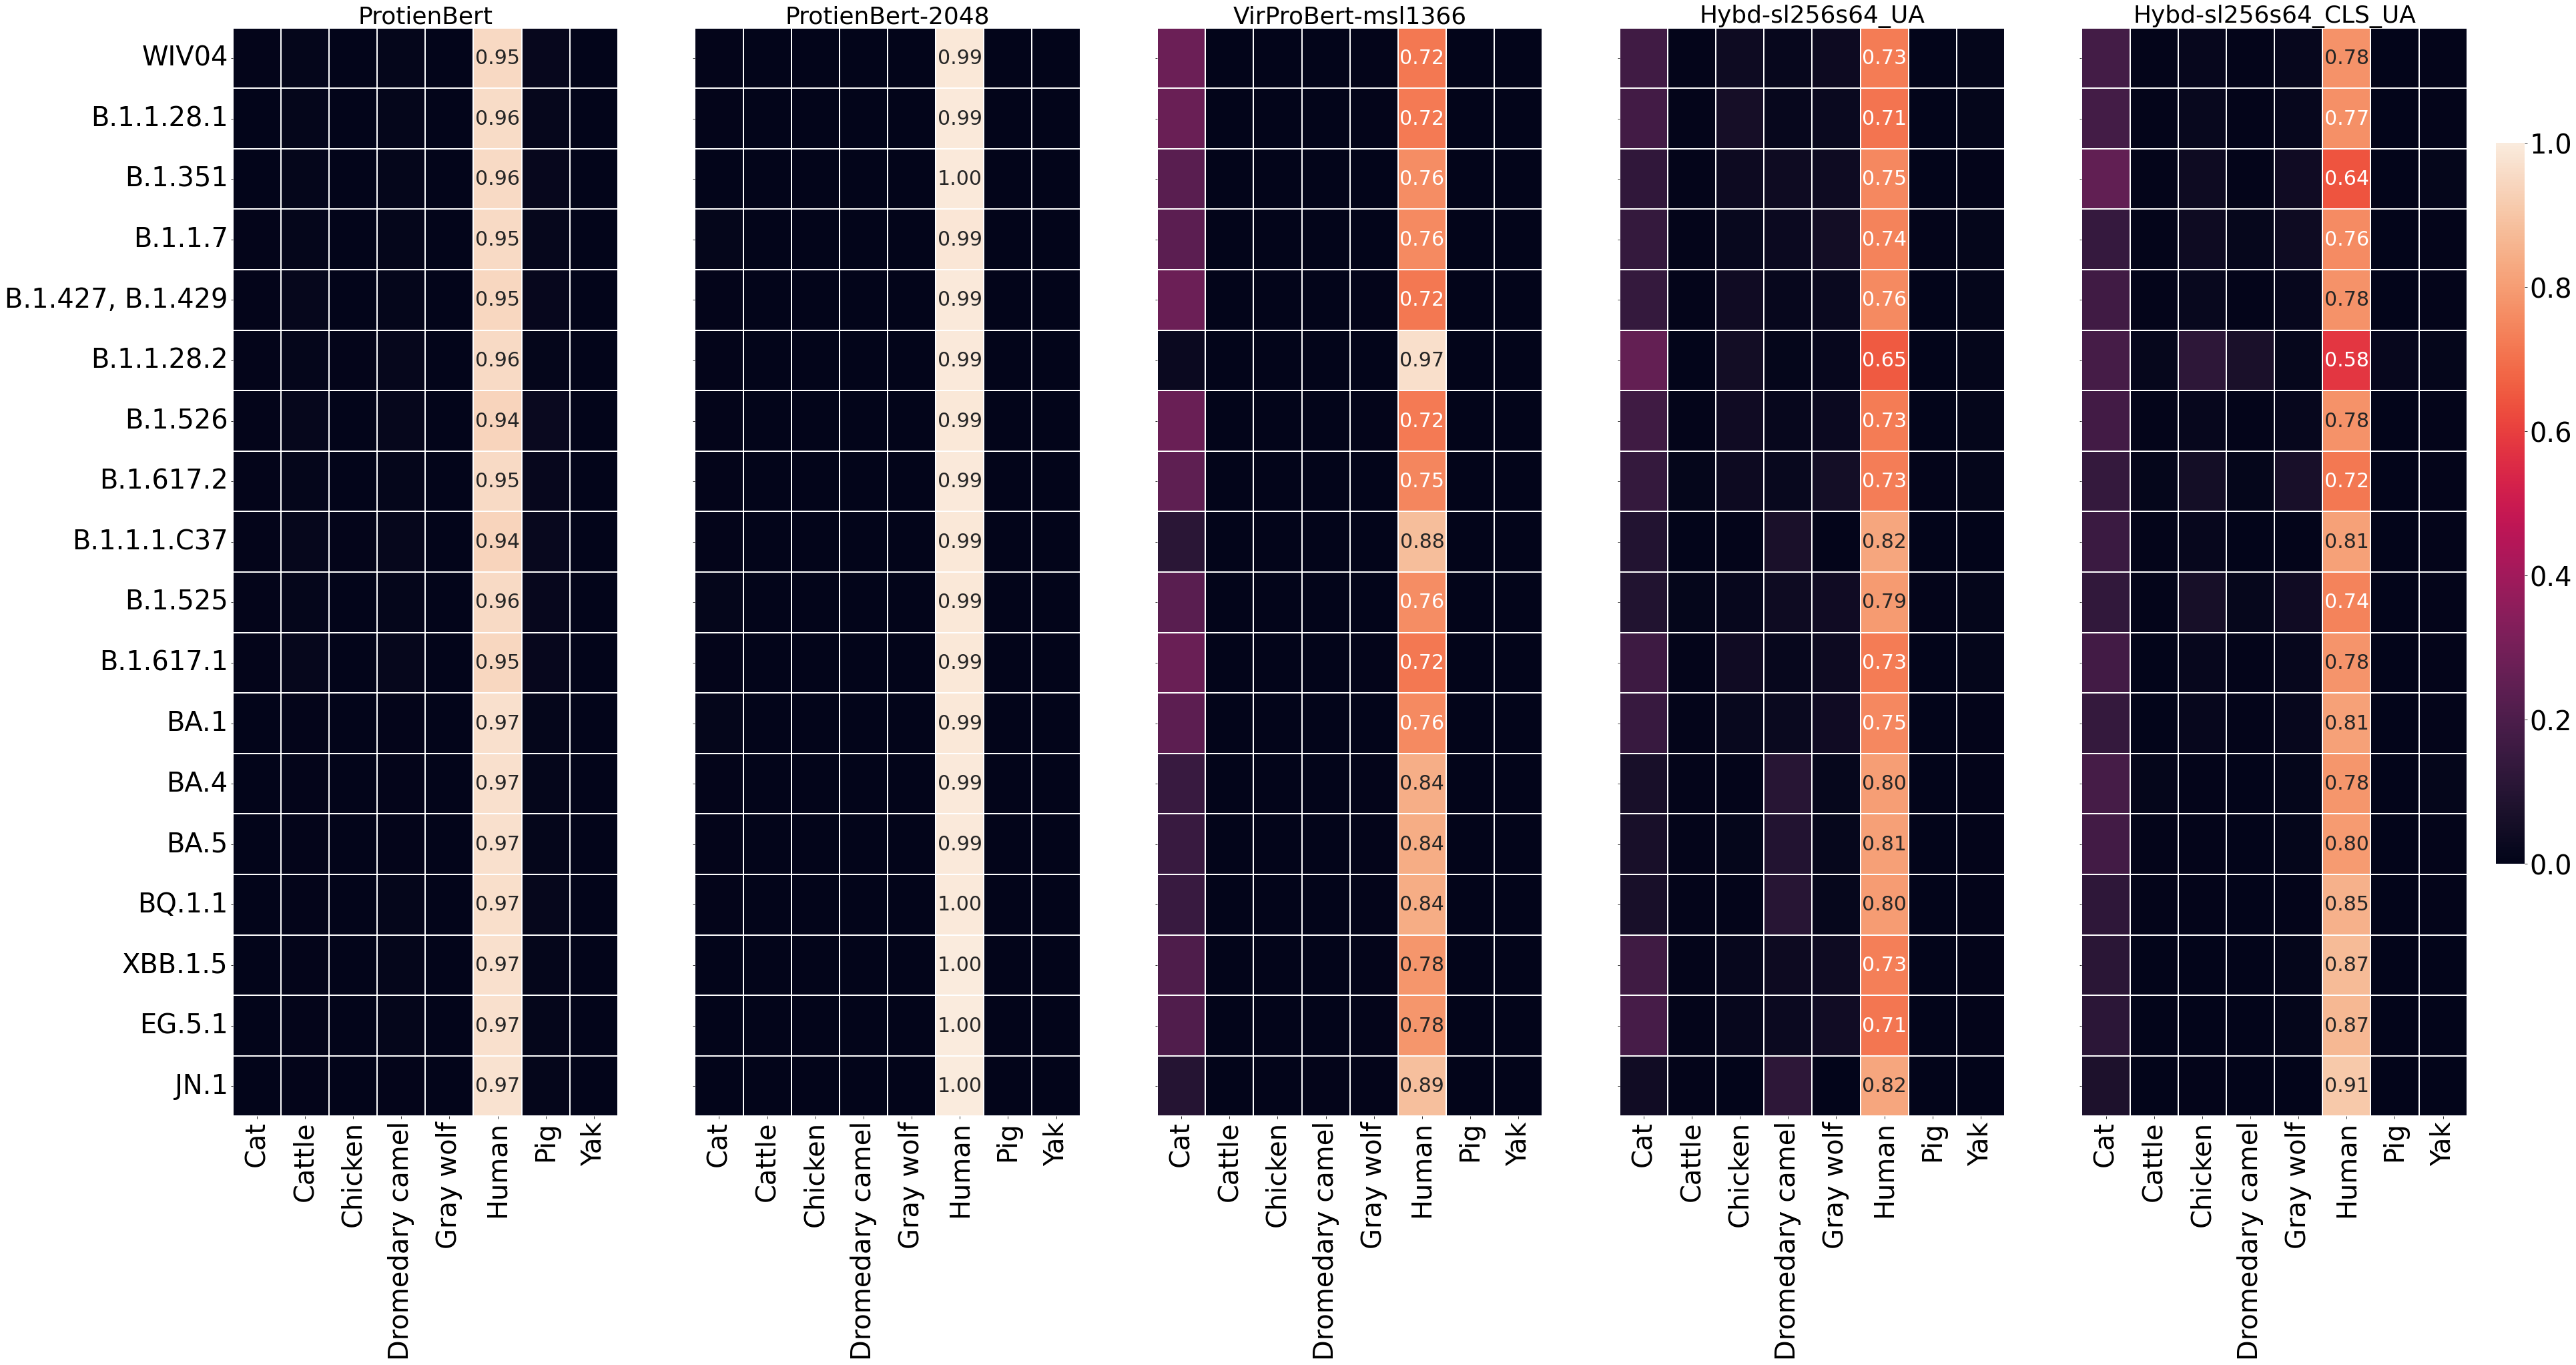

In [16]:
def get_annotation_df(heatmap_df):
    annot_df = pd.DataFrame(0, index=heatmap_df.index, columns=heatmap_df.columns)
    annot_idx = heatmap_df.idxmax(axis=1).reset_index()
    for item in annot_idx.values:
        annot_df.loc[item[0], item[1]] = "{:,.2f}".format(heatmap_df.loc[item[0], item[1]])
        annot_df.loc[item[0], "Human"] = "{:,.2f}".format(heatmap_df.loc[item[0], "Human"])
    annot_df = annot_df.astype(str)
    annot_df[annot_df == "0"] = ""
    
    return annot_df
 
fig, axs = plt.subplots(1, 5, figsize=(60, 30), sharex=False, sharey=True)

cbar_ax = fig.add_axes([.91, .3, .01, .5])
for i, model in enumerate(models):
    heatmap_df = df[df["model"] == model][["Cat", "Cattle", "Chicken", "Dromedary camel", "Gray wolf", "Human", "Pig", "Yak", "pango_lineage"]].set_index("pango_lineage").reindex(index=order)
    get_annotation_df(heatmap_df)
    sns.heatmap(heatmap_df, ax=axs[i], linewidth=.1,
                annot=get_annotation_df(heatmap_df), fmt="",
                vmin=0, vmax=1,
                cbar=i == 0, 
                cbar_ax=None if i != 0 else cbar_ax)
    axs[i].set_title(model)
    axs[i].set(xlabel="", ylabel="")

plt.show()